### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1844]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [1845]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        if criterion == 'gini':
            self.criterion = self.__giny_criterion
        elif criterion == 'entropy':
            self.criterion = self.__entropy_criterion
        elif criterion == 'classification_error':
            self.criterion = self.__classification_error_criterion
        else:
            raise Exception("Unknown criterion {}".format(criterion))
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
    
    
    def __classification_error_criterion(self, cumsum, sizes):
        return 1 - np.max(cumsum, axis=1) / sizes
    
    
    def __entropy_criterion(self, cumsum, sizes):
        pvm = cumsum / sizes[:, None]
        pvm = np.where(np.absolute(pvm) < 1e-15, 1e-15, pvm)
        return -np.sum(pvm * np.log(pvm), axis=1)
    
    
    def __giny_criterion(self, cumsum, sizes):
        return 1 - np.sum(np.square(cumsum), axis=1) / np.square(sizes)
        

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    

    def __process_col(self, col, y):
        ind = np.argsort(col)
        y = y[ind]
        obj = np.arange(y.size)
        
        onehot = np.zeros((y.size, self.num_class))
        onehot[obj, y] = 1
        
        left = np.cumsum(onehot, axis=0)
        right = left[-1][None, :] - left
        parent = left[-1][None, :]
        
        yl = np.arange(1, y.size + 1)
        yr = np.arange(y.size - 1, -1, -1)
        yr[-1] = 1
        yp = np.array([y.size])
        
        left_gain = self.criterion(left, yl)
        right_gain = self.criterion(right, yr)
        parent_gain = self.criterion(parent, yp)[0]
        
        yl = np.arange(1, y.size + 1)
        yr = np.arange(y.size - 1, -1, -1)
        yr[-1] = 1
        
        child_gain = (yl * left_gain + yr * right_gain) / y.size
        best_ind = np.argmin(child_gain)
        
        return parent_gain - child_gain[best_ind], col[ind[best_ind]]
        
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """

        res = np.array([self.__process_col(x[:, j], y) for j in range(x[0].size)])
        j_best = np.argmax(res[:, 0])
        q_max, thr_best = res[j_best]
            
        self.feature_importances_[j_best] += np.abs(q_max)
        return j_best, thr_best
 

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if x.shape[0] < self.min_samples_split or self.max_depth == depth:
            target = np.bincount(y)
            ind_max = np.argmax(target)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, ind_max, target[ind_max] / y.size)
            return
        
        j, thr = self.__find_threshold(x, y)
        xl, xr, yl, yr = self.__div_samples(x, y, j, thr)
        
        if yl.size == 0 or yr.size == 0:
            yt = yr if yl.size == 0 else yl
            target = np.bincount(yt)
            ind_max = np.argmax(target)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, ind_max, target[ind_max] / yt.size)
            return
        
        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, j, thr)
        self.__fit_node(xl, yl, node_id * 2 + 1, depth + 1)
        self.__fit_node(xr, yr, node_id * 2 + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(len(x[0]))
        
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ /= np.sum(self.feature_importances_)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [1846]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [1847]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [1848]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [1849]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [1850]:
%time clf.fit(X_train, y_train)

CPU times: user 1.93 ms, sys: 115 µs, total: 2.05 ms
Wall time: 2.24 ms


DecisionTreeClassifier()

In [1851]:
%time my_clf.fit(X_train, y_train)

CPU times: user 36.4 ms, sys: 3.08 ms, total: 39.5 ms
Wall time: 38.4 ms


In [1852]:
my_clf.get_feature_importance()

array([0.34372482, 0.20567266, 0.        , 0.        , 0.        ,
       0.        , 0.1161895 , 0.        , 0.        , 0.        ,
       0.06849856, 0.15313252, 0.11278193])

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


### Обработка данных

In [1853]:
def ohe(data, feature):
    for val in data[feature].unique():
        data[feature + '=' + str(val)] = (data[feature] == val).astype(float)

In [1854]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df.shape

df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 'age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'field',
              'prob_o','met_o', 'wave', 'undergra', 'from', 'zipcode', 'career', 'mn_sat', 'tuition'], axis=1)

df = df.dropna(subset=['age'])

ohe(df, 'field_cd')
ohe(df, 'race')
ohe(df, 'goal')
ohe(df, 'career_c')
ohe(df, 'go_out')
df = df.drop(['field_cd', 'race', 'goal', 'career_c', 'go_out'], axis=1)
df.shape

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

df.shape

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

df_female.rename(columns=lambda x: x.replace('iid_f', 'pid'), inplace=True)

new_df = df_male.merge(df_female.set_index('pid'), on='pid')
new_df = new_df.drop(['pid', 'iid', 'pid_f'], axis=1)

new_df['age'] -= new_df['age_f']
new_df = new_df.drop(['age_f'], axis=1)

for i in new_df.columns:
    if type(new_df[i].iloc[0]) not in [np.float64, np.int64, float]:
        new_df.drop(i, axis=1, inplace=True)
        
for i in new_df.columns:
    if i + '_f' in new_df.columns:
        new_df[i + '_res'] = new_df[i] - new_df[i + '_f']
        new_df.drop(i, axis=1, inplace=True)
        new_df.drop(i + '_f', axis=1, inplace=True)

for i in new_df.columns:
    if new_df[i].isnull().sum() > 0: 
        new_df.drop(i, axis=1, inplace=True)
        
new_df = new_df.fillna(-100000)
new_df = new_df.drop(['goal=nan_res', 'career_c=1.0_res', 'career_c=6.0_res'], axis=1)


y = new_df['match'].to_numpy()
new_df = new_df.drop(['match'], axis=1)
X = new_df.to_numpy()
X.shape, y.shape

((286, 96), (286,))

### Подбираем gain

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

Будем ориентироваться на accuracy.

In [1855]:
def get_score(clf, X, y, scorer=accuracy_score, n_splits=3):
    kf = KFold(n_splits)
    scores = []
    for train, test in kf.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        y_pred = clf.fit_predict(X_train, y_train, X_test)
        scores.append(scorer(y_test, y_pred))

    return np.mean(scores)

In [1856]:
ac_res = []
gains = ['gini', 'entropy', 'classification_error']

for gain in gains:
    clf = MyDecisionTreeClassifier(min_samples_split=10, max_depth=10, criterion=gain)
    ac_res.append(get_score(clf, X, y, accuracy_score))

In [1857]:
print('accuracy:')
for name, ac in zip(gains, ac_res):
    print(name, ac)

accuracy:
gini 0.7653143274853801
entropy 0.7618055555555555
classification_error 0.7547880116959065


Воспользуемся entropy.

### Подбираем max_depth

In [1858]:
scores = []
depths = np.arange(1, 15, 1)
for depth in depths:
    clf = MyDecisionTreeClassifier(min_samples_split=1, max_depth=depth, criterion='entropy')
    score = get_score(clf, X, y, n_splits=3)
    scores.append(score)

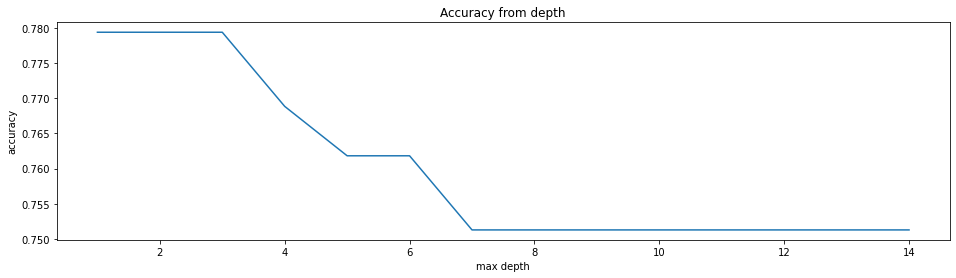

In [1859]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)

ax.set_title('Accuracy from depth')
ax.set_xlabel('max depth')
ax.set_ylabel('accuracy')
ax.plot(depths, scores)

### Подбираем min_samples

In [1860]:
scores = []
min_samples = np.arange(1, 25, 1)
for count in min_samples:
    clf = MyDecisionTreeClassifier(min_samples_split=count, max_depth=10, criterion='entropy')
    scores.append(get_score(clf, X, y, n_splits=3))

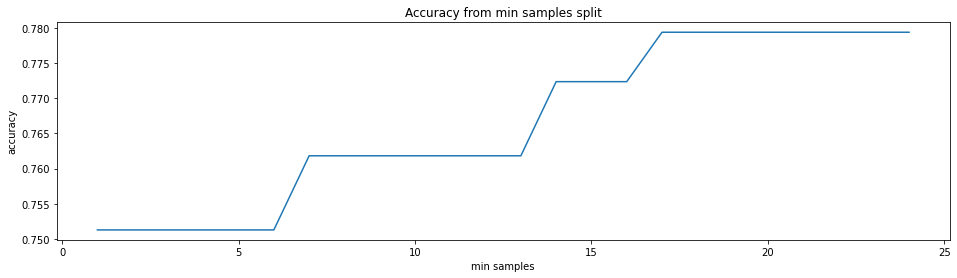

In [1861]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)

ax.set_title('Accuracy from min samples split')
ax.set_xlabel('min samples')
ax.set_ylabel('accuracy')
ax.plot(min_samples, scores)

In [1862]:
depth_best = 10
n_samples_best = 20

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [1863]:
clf = MyDecisionTreeClassifier(min_samples_split=n_samples_best, max_depth=depth_best, criterion='entropy')
clf.fit(X, y)

In [1864]:
imp = clf.get_feature_importance()
ind = np.nonzero(imp)
columns = new_df.columns[ind]
imp = imp[ind]

ind = np.argsort(imp)[::-1]

columns = columns[ind]
imp = imp[ind]
df = pd.DataFrame(imp, index=columns, columns=['importance'])
df

,importance
shar1_1_res,1.696186e-01
sinc1_1_res,1.530597e-01
yoga_res,1.440546e-01
field_cd=1.0_res,1.333222e-01
career_c=9.0_res,1.131888e-01
race=4.0_res,8.999716e-02
field_cd=8.0_res,7.871655e-02
go_out=3.0_res,6.261693e-02
field_cd=5.0_res,5.542555e-02
int_corr,2.358104e-29


In [1865]:
clf = DecisionTreeClassifier(min_samples_split=10, max_depth=10, criterion='entropy')
clf.fit(X, y)
imp = clf.feature_importances_
ind = np.nonzero(imp)
print(new_df.columns[ind])
print(imp[ind])

Index(['int_corr', 'age', 'imprace_res', 'imprelig_res', 'date_res',
       'clubbing_res', 'expnum_res', 'sinc1_1_res', 'intel1_1_res',
       'fun1_1_res', 'sinc2_1_res', 'shar2_1_res', 'field_cd=5.0_res',
       'field_cd=4.0_res', 'career_c=9.0_res', 'go_out=4.0_res'],
      dtype='object')
[0.03590269 0.03824455 0.07774646 0.04088101 0.06394275 0.04782329
 0.13960919 0.05066267 0.03908183 0.05304959 0.06185127 0.04061032
 0.08192247 0.05350184 0.12671168 0.04845838]


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Долго было непонятно, как оптимизировать время обучения. Было сложно обрабатывать данные, было непонятно, как к этому вообще подойти. Нет уверенности, что для оценки качества выбрана "правильная" метрика. Было не очень понятно, как подбирать минимальное число сэмплов в листе - при наилучшем max_depth или при максимально возможном max_depth

### ВАШ ОТЗЫВ ЗДЕСЬ



После лекций тема деревьев прошла как-то мимо. После выполнения задания понимание, как работают деревья, пришло :)